In [1]:
# Library Import
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import statistics
import scipy.signal
from math import log, log10, exp, e, pow, sqrt
import numpy as np
from scipy import integrate
from datetime import datetime
import datetime
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
##################################Ridership data######################################

In [3]:
# Import trip data
trip_df = []
trip_file = os.listdir()
trip_filename = list(filter(lambda x:'bike_share_2020' in x or 'bike_share_2021' in x or 'bike_share_2022' in x, trip_file))

# Clean trip data (column name)
for filename in trip_filename:
    temp_df = pd.read_csv(filename)
    temp_df.columns = temp_df.columns.str.replace(' ', '_')
    temp_df.columns = temp_df.columns.str.title()
    temp_df = temp_df.rename(columns = {'Trip__Duration': 'Trip_Duration'})
    temp_df = temp_df.rename(columns = {'Ï»¿Trip_Id': 'Trip_Id'})
    trip_df.append(temp_df)

# Unify the datetime column of dataset, make the format the same and count the day only
trip_data = pd.concat(trip_df, ignore_index = True, axis = 0)
trip_data['Start_Time'] = trip_data['Start_Time'].str[:10]
trip_data['End_Time'] = trip_data['End_Time'].str[:10]
trip_data['Start_Time'] = pd.to_datetime(trip_data['Start_Time'], format = '%d/%m/%Y', utc = True)
trip_data['End_Time'] = pd.to_datetime(trip_data['End_Time'], format = '%d/%m/%Y', utc = True)
trip_data['Start_Time'] = trip_data['Start_Time'].dt.tz_convert(tz = 'EST')
trip_data['End_Time'] = trip_data['End_Time'].dt.tz_convert(tz = 'EST')
trip_data.drop(columns = ['Subscription_Id', 'Bike_Id'], inplace = True)
trip_data.head(5)

,Trip_Id,Trip_Duration,Start_Station_Id,Start_Time,Start_Station_Name,End_Station_Id,End_Time,End_Station_Name,User_Type
0,7334128,648,7003,2019-12-31 19:00:00-05:00,Madison Ave / Bloor St W,7271.0,2019-12-31 19:00:00-05:00,Yonge St / Alexander St - SMART,Annual Member
1,7334129,419,7007,2019-12-31 19:00:00-05:00,College St / Huron St,7163.0,2019-12-31 19:00:00-05:00,Yonge St / Wood St,Annual Member
2,7334130,566,7113,2019-12-31 19:00:00-05:00,Parliament St / Aberdeen Ave,7108.0,2019-12-31 19:00:00-05:00,Front St E / Cherry St,Annual Member
3,7334131,1274,7333,2019-12-31 19:00:00-05:00,King St E / Victoria St,7311.0,2019-12-31 19:00:00-05:00,Sherbourne St / Isabella St,Annual Member
4,7334132,906,7009,2019-12-31 19:00:00-05:00,King St E / Jarvis St,7004.0,2019-12-31 19:00:00-05:00,University Ave / Elm St,Casual Member


In [97]:
trip_data.columns

Index(['Start_Time', 'End_Time', 'User_Type', 'Merge_Time'], dtype='object')

In [4]:
#Deal with outlier of trip duration 
trip_data = trip_data.drop(trip_data[trip_data['Trip_Duration'] < 60].index)

Q1 = trip_data['Trip_Duration'].quantile(0.25)
Q3 = trip_data['Trip_Duration'].quantile(0.75)
IQR = Q3 - Q1
const_1 = Q1 - 1.5*IQR
const_2 = Q3 + 1.5*IQR
trip_data = trip_data.drop(trip_data[(trip_data['Trip_Duration'] < const_1) | (trip_data['Trip_Duration'] > const_2)].index)

trip_data.head()

,Trip_Id,Trip_Duration,Start_Station_Id,Start_Time,Start_Station_Name,End_Station_Id,End_Time,End_Station_Name,User_Type
0,7334128,648,7003,2019-12-31 19:00:00-05:00,Madison Ave / Bloor St W,7271.0,2019-12-31 19:00:00-05:00,Yonge St / Alexander St - SMART,Annual Member
1,7334129,419,7007,2019-12-31 19:00:00-05:00,College St / Huron St,7163.0,2019-12-31 19:00:00-05:00,Yonge St / Wood St,Annual Member
2,7334130,566,7113,2019-12-31 19:00:00-05:00,Parliament St / Aberdeen Ave,7108.0,2019-12-31 19:00:00-05:00,Front St E / Cherry St,Annual Member
3,7334131,1274,7333,2019-12-31 19:00:00-05:00,King St E / Victoria St,7311.0,2019-12-31 19:00:00-05:00,Sherbourne St / Isabella St,Annual Member
4,7334132,906,7009,2019-12-31 19:00:00-05:00,King St E / Jarvis St,7004.0,2019-12-31 19:00:00-05:00,University Ave / Elm St,Casual Member


In [5]:
#Drop station information since it is less correlative to covid influence on trip data 
trip_data = trip_data.drop_duplicates(subset=['Trip_Id'])
trip_data = trip_data.drop(columns = ['Trip_Id', 'Trip_Duration',
                            'Start_Station_Id', 'Start_Station_Name',
                            'End_Station_Id', 'End_Station_Name'])
print(trip_data.isnull().sum())
trip_data = trip_data.dropna()

Start_Time    0
End_Time      0
User_Type     0
dtype: int64


In [6]:
###############################Weather data##################################

In [7]:
#Import weather data
import time
weather_df = []
weather_file = os.listdir()
weather_filename = list(filter(lambda x: '6158359' in x, weather_file))

for filename in weather_filename:
    temp_weather_df = pd.read_csv(filename)
    
    if 'Date/Time' in temp_weather_df.columns:
        temp_weather_df = temp_weather_df.rename(columns = {'Date/Time': 'weather_date'})
        temp_weather_df['weather_date'] = pd.to_datetime(temp_weather_df['weather_date'])
        temp_weather_df = temp_weather_df.set_index(temp_weather_df['weather_date'])
    
    else:
        temp_weather_df = temp_weather_df.rename(columns = {'Date/Time (LST)': 'weather_date'})
        temp_weather_df['weather_date'] = pd.to_datetime(temp_weather_df['weather_date'])
        temp_weather_df = temp_weather_df.set_index(temp_weather_df['weather_date'])

    weather_df.append(temp_weather_df)

weather_data = pd.concat(weather_df)
weather_data.drop(columns = ['weather_date'])
weather_data.index = weather_data.index.tz_localize(tz = 'EST')
weather_data.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,weather_date,Year,Month,Day,Time,Temp (°C),...,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather,Time (LST),Precip. Amount (mm),Precip. Amount Flag
weather_date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 00:00:00,2017,1,1,00:00,1.5,...,99.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 01:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 01:00:00,2017,1,1,01:00,1.5,...,100.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 02:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 02:00:00,2017,1,1,02:00,1.0,...,100.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 03:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 03:00:00,2017,1,1,03:00,1.2,...,100.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 04:00:00-05:00,-79.4,43.63,TORONTO CITY CENTRE,6158359,2017-01-01 04:00:00,2017,1,1,04:00,1.3,...,100.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Drop none-numerical columns, location columns, and date information
weather_data = weather_data.drop(columns = ['Longitude (x)', 'Latitude (y)',
                             'Year', 'Month', 'Day', 'Time (LST)', 'Time',
                            'Station Name', 'Climate ID',
                            'Temp Flag', 'Dew Point Temp Flag', 'Rel Hum Flag', 'Precip. Amount Flag', 'Wind Dir Flag', 'Wind Spd Flag', 'Visibility Flag', 'Stn Press Flag', 'Hmdx Flag', 'Wind Chill Flag'])

In [9]:
#############Weather and ridership data merge#####################

In [10]:
#Merge weather and trip on hour
weather_data['Merge_Time'] = weather_data.index
trip_data['Merge_Time'] = trip_data['Start_Time'].dt.floor('H')
data_merged = pd.merge(trip_data, weather_data, on = 'Merge_Time')
data_merged = data_merged.drop(columns = ['Start_Time', 'End_Time', 'weather_date'])
data_merged.head()

,User_Type,Merge_Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather,Precip. Amount (mm)
0,Annual Member,2019-12-31 19:00:00-05:00,0.7,-3.7,72.0,25.0,39.0,16.1,99.18,NaN,NaN,NaN,NaN
1,Annual Member,2019-12-31 19:00:00-05:00,0.7,-3.7,72.0,25.0,39.0,16.1,99.18,NaN,NaN,NaN,NaN
2,Annual Member,2019-12-31 19:00:00-05:00,0.7,-3.7,72.0,25.0,39.0,16.1,99.18,NaN,NaN,NaN,NaN
3,Annual Member,2019-12-31 19:00:00-05:00,0.7,-3.7,72.0,25.0,39.0,16.1,99.18,NaN,NaN,NaN,NaN
4,Casual Member,2019-12-31 19:00:00-05:00,0.7,-3.7,72.0,25.0,39.0,16.1,99.18,NaN,NaN,NaN,NaN


In [11]:
#Convert hourly data to daily data using aggregate function
data_merged['Merge_Day'] = data_merged['Merge_Time'].dt.floor('D')
data_days = data_merged.groupby('Merge_Day').agg(
    rides = pd.NamedAgg(column = 'Merge_Day', aggfunc = 'count'),
    annual_members = pd.NamedAgg(column = 'User_Type', aggfunc = lambda x: x[x == 'Annual Member'].count()),
    casual_members = pd.NamedAgg(column = 'User_Type', aggfunc = lambda x: x[x == 'Casual Member'].count()),
    workday = pd.NamedAgg(column = 'Merge_Day', aggfunc = lambda x: pd.to_datetime(x, format='%Y-%m-%d %h:%m:%s-%h:%m').dt.day_of_week.max()<5),
    temp = pd.NamedAgg(column = 'Temp (°C)', aggfunc = 'mean'),
    dew_temp = pd.NamedAgg(column = 'Dew Point Temp (°C)', aggfunc = 'mean'),
    rh = pd.NamedAgg(column = 'Rel Hum (%)', aggfunc = 'mean'),
    prec = pd.NamedAgg(column = 'Precip. Amount (mm)', aggfunc = 'mean'),
    wind_dir = pd.NamedAgg(column = 'Wind Dir (10s deg)', aggfunc = 'mean'),
    wind_speed = pd.NamedAgg(column = 'Wind Spd (km/h)', aggfunc = 'mean'),
    visibility = pd.NamedAgg(column = 'Visibility (km)', aggfunc = 'mean'),
    press = pd.NamedAgg(column = 'Stn Press (kPa)', aggfunc = 'mean'),
    hmdx = pd.NamedAgg(column = 'Hmdx', aggfunc = 'mean'),
    wind_chill = pd.NamedAgg(column = 'Wind Chill', aggfunc = 'mean'),
    weather = pd.NamedAgg(column = 'Weather', aggfunc = lambda x: 'clear' if x.isnull().mean() >=0.5 else 'Percipitation')
).reset_index().rename(columns={'Merge_Day': 'Start_Time'}).set_index('Start_Time', drop=True)
data_days.head()

,rides,annual_members,casual_members,workday,temp,dew_temp,rh,prec,wind_dir,wind_speed,visibility,press,hmdx,wind_chill,weather
Start_Time,,,,,,,,,,,,,,,
2019-12-31 00:00:00-05:00,1329,1107,222,True,0.7,-3.7,72.0,NaN,25.0,39.0,16.1,99.18,NaN,NaN,clear
2020-01-01 00:00:00-05:00,3718,3437,281,True,-0.5,-4.9,72.0,NaN,23.0,28.0,16.1,99.93,NaN,-7.0,clear
2020-01-02 00:00:00-05:00,4351,3955,396,True,4.1,1.6,84.0,NaN,25.0,11.0,16.1,99.61,NaN,NaN,clear
2020-01-03 00:00:00-05:00,2367,2171,196,True,6.0,-0.4,64.0,NaN,29.0,11.0,16.1,100.07,NaN,NaN,clear
2020-01-04 00:00:00-05:00,1951,1823,128,False,1.9,-2.5,73.0,NaN,28.0,21.0,16.1,99.98,NaN,NaN,clear


In [12]:
#Deal with date time column
date_list = []
data_days = data_days.reset_index()
for date in data_days['Start_Time']:
    date = date.date()
    date_list.append(date)
data_days['date'] = date_list
data_days = data_days.drop('Start_Time',axis = 1)
data_days.head()

,rides,annual_members,casual_members,workday,temp,dew_temp,rh,prec,wind_dir,wind_speed,visibility,press,hmdx,wind_chill,weather,date
0,1329,1107,222,True,0.7,-3.7,72.0,NaN,25.0,39.0,16.1,99.18,NaN,NaN,clear,2019-12-31
1,3718,3437,281,True,-0.5,-4.9,72.0,NaN,23.0,28.0,16.1,99.93,NaN,-7.0,clear,2020-01-01
2,4351,3955,396,True,4.1,1.6,84.0,NaN,25.0,11.0,16.1,99.61,NaN,NaN,clear,2020-01-02
3,2367,2171,196,True,6.0,-0.4,64.0,NaN,29.0,11.0,16.1,100.07,NaN,NaN,clear,2020-01-03
4,1951,1823,128,False,1.9,-2.5,73.0,NaN,28.0,21.0,16.1,99.98,NaN,NaN,clear,2020-01-04


In [13]:
#Drop data before 2020-02-04
data_days_after_20200204 = data_days[(data_days['date']>= datetime.date(2020, 2, 4))]
data_days_after_20200204.head()

,rides,annual_members,casual_members,workday,temp,dew_temp,rh,prec,wind_dir,wind_speed,visibility,press,hmdx,wind_chill,weather,date
35,4694,4525,169,True,1.2,-5.1,63.0,NaN,34.0,18.0,16.1,100.60,NaN,NaN,clear,2020-02-04
36,2055,1917,138,True,-3.5,-10.3,60.0,NaN,7.0,13.0,16.1,100.89,NaN,-8.0,clear,2020-02-05
37,1815,1727,88,True,-3.3,-6.8,77.0,NaN,5.0,18.0,14.5,99.08,NaN,-9.0,clear,2020-02-06
38,1540,1339,201,True,-5.3,-12.3,58.0,NaN,29.0,24.0,16.1,99.62,NaN,-13.0,clear,2020-02-07
39,1564,1394,170,False,-7.5,-12.4,68.0,NaN,11.0,8.0,16.1,101.71,NaN,-12.0,clear,2020-02-08


In [14]:
####################################COVID data#####################################

In [15]:
from datetime import datetime
covid_df = []
covid_file = os.listdir()
covid_filename = list(filter(lambda x:'data_download' in x, covid_file))

for filename in covid_filename:
    temp_df = pd.read_csv(filename)
    temp_df = temp_df[temp_df['location_name'] == 'Canada']
    covid_df.append(temp_df)

covid_data = pd.concat(covid_df, ignore_index = True, axis = 0)

# convert string to datetime date
datetime_list = []
for time in covid_data['date']:
    format = '%Y/%m/%d'
    datetime_time = datetime.strptime(time.replace('-','/'),format).date()
    datetime_list.append(datetime_time)
covid_data['date'] = datetime_list

In [16]:
# Check nan values
nanlist = covid_data.isna().sum()!=0 
nan_column = pd.DataFrame()
nan_column['nan'] = nanlist
nan_column[nan_column['nan'] == True].index

Index(['reff_mean', 'reff_lower', 'reff_upper', 'cumulative_deaths',
       'daily_deaths', 'cumulative_cases', 'cumulative_hospitalizations',
       'cumulative_deaths_unscaled', 'daily_deaths_unscaled', 'daily_cases',
       'cumulative_all_vaccinated', 'cumulative_all_fully_vaccinated',
       'cumulative_all_effectively_vaccinated'],
      dtype='object')

In [17]:
# fill nan with meanvalues
for nacolumns in nan_column[nan_column['nan'] == True].index:
    covid_data[nacolumns] = covid_data[nacolumns].fillna(covid_data[nacolumns].mean())
covid_data

# Drop all nan columns
covid_data = covid_data.drop(['reff_mean', 'reff_lower', 'reff_upper','infection_fatality', 'location_id', 'version_name', 'location_name'],axis = 1)

In [18]:
#Drop the colomns that describe the same feature
covid_data = covid_data.drop(covid_data.filter(regex='upper|lower').columns, axis=1)

Now the data is cleaned with only numerical values

In [19]:
covid_data.columns

Index(['date', 'inf_mean', 'seir_cumulative_mean', 'inf_cuml_mean',
       'seir_daily_mean', 'seir_daily_unscaled_mean',
       'seir_cumulative_unscaled_mean', 'cases_mean', 'inf_cuml_mean_vax',
       'inf_cuml_mean_unvax', 'inf_mean_vax', 'inf_mean_unvax',
       'cumulative_deaths', 'daily_deaths', 'cumulative_cases',
       'cumulative_hospitalizations', 'cumulative_deaths_unscaled',
       'daily_deaths_unscaled', 'daily_cases', 'population', 'pneumonia_mean',
       'pneumonia_obs', 'mask_use_mean', 'mask_use_obs',
       'cumulative_all_vaccinated', 'cumulative_all_fully_vaccinated',
       'cumulative_all_effectively_vaccinated', 'hospital_beds_mean',
       'icu_beds_mean', 'admis_mean', 'admis_mean_vax', 'admis_mean_unvax',
       'all_bed_capacity', 'icu_bed_capacity', 'infection_detection',
       'infection_hospitalization'],
      dtype='object')

In [20]:
import datetime
covid_data_before_20220830 = covid_data[(covid_data['date']<= datetime.date(2022, 8, 30))]
covid_data_after_20220830 = covid_data[(covid_data['date']>= datetime.date(2022, 8, 30))]

In [21]:
covid_data_before_20220830.head()

,date,inf_mean,seir_cumulative_mean,inf_cuml_mean,seir_daily_mean,seir_daily_unscaled_mean,seir_cumulative_unscaled_mean,cases_mean,inf_cuml_mean_vax,inf_cuml_mean_unvax,...,cumulative_all_effectively_vaccinated,hospital_beds_mean,icu_beds_mean,admis_mean,admis_mean_vax,admis_mean_unvax,all_bed_capacity,icu_bed_capacity,infection_detection,infection_hospitalization
0,2020-02-04,34.34,0.06,785.82,0.06,0.04,0.04,0.69,0.0,785.821621,...,2.107624e+07,6.72,2.70,0.94,0.0,0.942791,86460.0,4048.0,0.0262,0.0337
1,2020-02-05,34.58,0.12,820.40,0.06,0.04,0.08,0.44,0.0,820.399018,...,2.107624e+07,7.31,2.93,0.76,0.0,0.756101,86460.0,4048.0,0.0144,0.0245
2,2020-02-06,35.73,0.18,856.13,0.06,0.04,0.11,0.42,0.0,856.127264,...,2.107624e+07,7.82,3.14,0.71,0.0,0.705766,86460.0,4048.0,0.0120,0.0198
3,2020-02-07,38.24,0.24,894.37,0.06,0.04,0.15,0.38,0.0,894.370921,...,2.107624e+07,8.33,3.34,0.70,0.0,0.702697,86460.0,4048.0,0.0096,0.0173
4,2020-02-08,40.35,0.30,934.72,0.06,0.04,0.19,0.35,0.0,934.722098,...,2.107624e+07,8.82,3.54,0.70,0.0,0.695029,86460.0,4048.0,0.0087,0.0171


<AxesSubplot:>

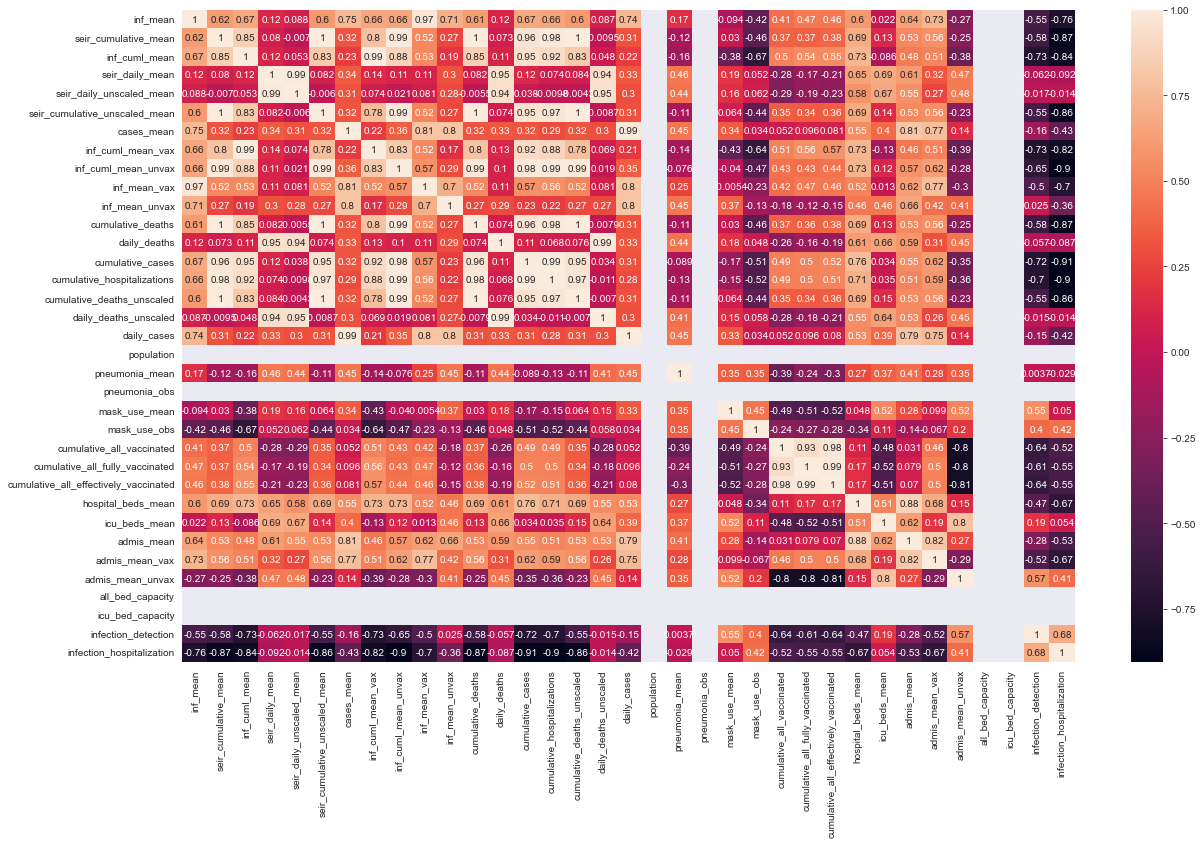

In [22]:
cor = covid_data_before_20220830.corr()
import seaborn as sns
plt.figure(figsize = (20, 12))
sns.heatmap(cor, annot = True)

In [23]:
####################################Combineddata############################################

In [24]:
merged_final = covid_data_before_20220830.merge(data_days_after_20200204, left_on='date',right_on='date')

In [25]:
# Check nan values
nanlist = merged_final.isna().sum()!=0 
nan_column = pd.DataFrame()
nan_column['nan'] = nanlist
nan_column[nan_column['nan'] == True].index

# fill nan with meanvalues
for nacolumns in nan_column[nan_column['nan'] == True].index:
    merged_final[nacolumns] = merged_final[nacolumns].fillna(merged_final[nacolumns].mean())


# # Drop all nan columns
# covid_data = covid_data.drop(['reff_mean', 'reff_lower', 'reff_upper','infection_fatality'],axis = 1)

In [26]:
merged_final = merged_final.drop(columns = ['rides'])
merged_final.head()

,date,inf_mean,seir_cumulative_mean,inf_cuml_mean,seir_daily_mean,seir_daily_unscaled_mean,seir_cumulative_unscaled_mean,cases_mean,inf_cuml_mean_vax,inf_cuml_mean_unvax,...,dew_temp,rh,prec,wind_dir,wind_speed,visibility,press,hmdx,wind_chill,weather
0,2020-02-04,34.34,0.06,785.82,0.06,0.04,0.04,0.69,0.0,785.821621,...,-5.1,63.0,0.073981,34.0,18.0,16.1,100.60,29.744681,-10.992366,clear
1,2020-02-05,34.58,0.12,820.40,0.06,0.04,0.08,0.44,0.0,820.399018,...,-10.3,60.0,0.073981,7.0,13.0,16.1,100.89,29.744681,-8.000000,clear
2,2020-02-06,35.73,0.18,856.13,0.06,0.04,0.11,0.42,0.0,856.127264,...,-6.8,77.0,0.073981,5.0,18.0,14.5,99.08,29.744681,-9.000000,clear
3,2020-02-07,38.24,0.24,894.37,0.06,0.04,0.15,0.38,0.0,894.370921,...,-12.3,58.0,0.073981,29.0,24.0,16.1,99.62,29.744681,-13.000000,clear
4,2020-02-08,40.35,0.30,934.72,0.06,0.04,0.19,0.35,0.0,934.722098,...,-12.4,68.0,0.073981,11.0,8.0,16.1,101.71,29.744681,-12.000000,clear


In [27]:
merged_final.columns

Index(['date', 'inf_mean', 'seir_cumulative_mean', 'inf_cuml_mean',
       'seir_daily_mean', 'seir_daily_unscaled_mean',
       'seir_cumulative_unscaled_mean', 'cases_mean', 'inf_cuml_mean_vax',
       'inf_cuml_mean_unvax', 'inf_mean_vax', 'inf_mean_unvax',
       'cumulative_deaths', 'daily_deaths', 'cumulative_cases',
       'cumulative_hospitalizations', 'cumulative_deaths_unscaled',
       'daily_deaths_unscaled', 'daily_cases', 'population', 'pneumonia_mean',
       'pneumonia_obs', 'mask_use_mean', 'mask_use_obs',
       'cumulative_all_vaccinated', 'cumulative_all_fully_vaccinated',
       'cumulative_all_effectively_vaccinated', 'hospital_beds_mean',
       'icu_beds_mean', 'admis_mean', 'admis_mean_vax', 'admis_mean_unvax',
       'all_bed_capacity', 'icu_bed_capacity', 'infection_detection',
       'infection_hospitalization', 'annual_members', 'casual_members',
       'workday', 'temp', 'dew_temp', 'rh', 'prec', 'wind_dir', 'wind_speed',
       'visibility', 'press', 'hmd

In [28]:
merged_final[['annual_members', 'casual_members']]

,annual_members,casual_members
0,4525,169
1,1917,138
2,1727,88
3,1339,201
4,1394,170
...,...,...
934,8685,18061
935,7779,16446
936,8713,11636
937,7918,9940


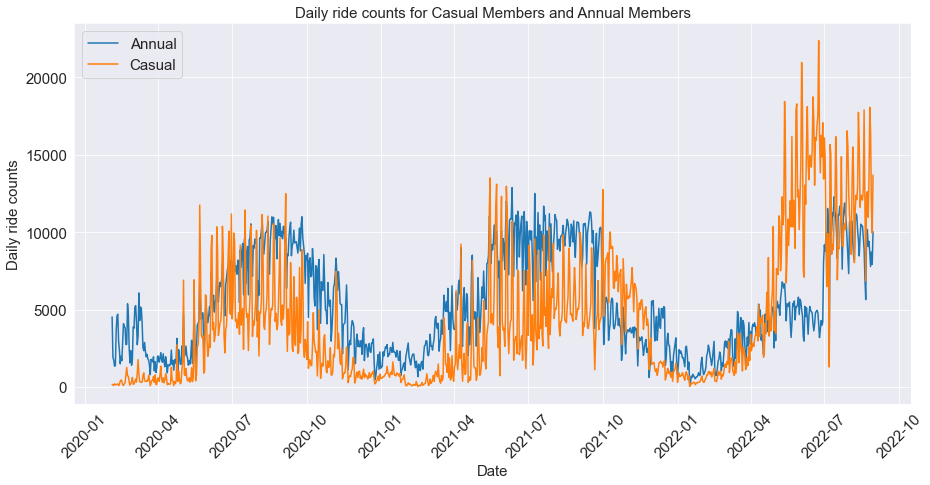

In [29]:
plt.figure(figsize = (15, 7))

sns.lineplot(data = merged_final, x = 'date', y ='annual_members' )
sns.lineplot(data = merged_final, x = 'date', y ='casual_members' )

# set plot title, labels, and legends
plt.title('Daily ride counts for Casual Members and Annual Members', fontsize = 15)
plt.ylabel('Daily ride counts', fontsize = 15)
plt.xlabel('Date', fontsize = 15)

plt.xticks(rotation = 45, fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(labels = ['Annual', 'Casual'], fontsize = 15)

In [30]:
#Convert categorical feature to numerical
merged_final = pd.get_dummies(merged_final, columns = ['weather', 'workday'], drop_first = True)

In [31]:
cat_label = ['weather_clear', 'workday_True']
int_label = ['pneumonia_obs', 'mask_use_obs']
merged_final[cat_label] = merged_final[cat_label].astype('category')
merged_final[int_label] = merged_final[int_label].astype('float')

In [32]:
#Split data based on date, future data will be used to do prediction
merged_final_future = merged_final[(merged_final['date'] >= datetime.date(2022, 5, 30))]
len(merged_final_future)

93

In [33]:
merged_final_present = merged_final[(merged_final['date'] < datetime.date(2022, 5, 30))]
len(merged_final_present)

846

In [34]:
##############################Annual member###################################

In [35]:
#############################Train test split for annual member###################

In [36]:
import datetime as dt
merged_annual = merged_final_present.drop(columns = ['casual_members'])
merge_train_annual = merged_annual[(merged_annual['date'] < datetime.date(2021, 12, 31))]
merge_test_annual = merged_annual[(merged_annual['date'] > datetime.date(2021, 12 , 31))]
print(len(merge_train_annual))
print(len(merge_test_annual))

696
149


In [37]:
y_train_annual = pd.DataFrame(merge_train_annual['annual_members'].to_list(), 
                        index = merge_train_annual.index,
                        columns = ['num_annual'])
X_train_annual = merge_train_annual.drop(columns = ['annual_members', 'date'])

y_test_annual = pd.DataFrame(merge_test_annual['annual_members'].to_list(), 
                        index = merge_test_annual.index,
                        columns = ['num_annual'])
X_test_annual = merge_test_annual.drop(columns = ['annual_members', 'date'])

In [38]:
#################Feature Selection for annual member data#################

In [39]:
targets_annual = X_train_annual.columns

In [40]:
column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_exclude=['category'])),
        ('cat', OrdinalEncoder(), selector(dtype_include=['category']))],
        remainder='drop')
clf = RandomForestClassifier(random_state = 999, class_weight = 'balanced')
pipeline = Pipeline([('prep', column_trans),
                     ('clf', clf)])

pipeline.fit(X_train_annual, y_train_annual)
pipeline['clf'].feature_importances_

feat_list = []

In [41]:
total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(targets_annual, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]

included_feats = []
# Print the name and gini importance of each feature
for feature in zip(targets_annual, pipeline['clf'].feature_importances_):
    if feature[1] > .034:
        included_feats.append(feature[0])

print('\n',"Cumulative Importance =", total_importance)

# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp

print('Most Important Features:')
print(included_feats)
print('Number of Included Features =', len(included_feats))


 Cumulative Importance = 1.0000000000000002
Most Important Features:
['infection_detection', 'dew_temp', 'rh', 'press']
Number of Included Features = 4


In [42]:
selected_fea_annual = included_feats

In [43]:
##############Linear Regression for annual member##################

In [44]:
linear_model_annual = LinearRegression(fit_intercept = True)

In [45]:
linear_model_annual.fit(X_train_annual[selected_fea_annual], y_train_annual)
y_fitted_annual = linear_model_annual.predict(X_train_annual[selected_fea_annual])

In [46]:
linear_model_annual.coef_

array([[1607.84524773,  293.8257726 ,  -62.27476072,  571.48091127]])

In [47]:
linear_model_annual.intercept_

array([-49729.17326609])

In [48]:
def rmse(actual, predicted):
    se = (actual - predicted)**2
    mse = np.mean(se)
    rmse = np.sqrt(mse)
    
    return rmse    

In [49]:
training_error_annual = rmse(y_train_annual, y_fitted_annual)
training_mae_annual = mean_absolute_error(y_train_annual, y_fitted_annual)
r2_score_training_annual = r2_score(y_train_annual, y_fitted_annual)

print('Training RMSE: {}'.format(training_error_annual))
print('Training MAE: {}'.format(training_mae_annual))
print('Training R2 score: {}'.format(r2_score_training_annual))

Training RMSE: num_annual    1907.904
dtype: float64
Training MAE: 1534.1531634914188
Training R2 score: 0.6457128072426459


In [50]:
# Prediction on test set
y_pred_test_annual = linear_model_annual.predict(X_test_annual[selected_fea_annual])

test_error_annual = rmse(y_test_annual, y_pred_test_annual)
test_mae_annual = mean_absolute_error(y_test_annual, y_pred_test_annual)
r2_score_test_annual = r2_score(y_test_annual, y_pred_test_annual)

print('Test RMSE: {}'.format(test_error_annual))
print('Training MAE: {}'.format(test_mae_annual))
print('Test R2 score: {}'.format(r2_score_test_annual))

Test RMSE: num_annual    1122.682798
dtype: float64
Training MAE: 906.1011413659465
Test R2 score: 0.5319950484616585


In [51]:
x_axis_annual = np.arange(len(y_test_annual))
annual_data = pd.concat([pd.DataFrame(x_axis_annual), y_test_annual.reset_index(), pd.DataFrame(y_pred_test_annual)],axis =1, ignore_index = True)
annual_data.columns = ['x_axis', 'index', 'true', 'predicted']

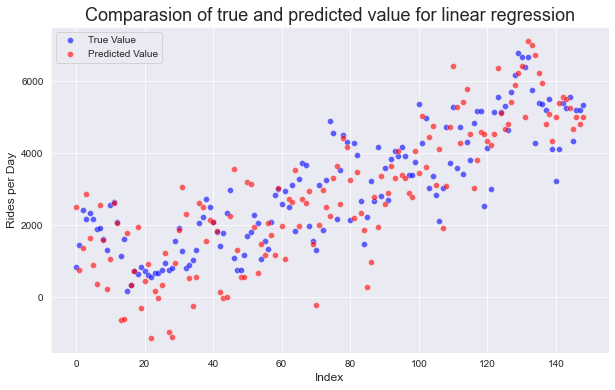

In [52]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = annual_data, x = 'x_axis', y = 'true', color = 'b', label = 'True Value', alpha = 0.6)
sns.scatterplot(data = annual_data, x = 'x_axis', y = 'predicted', color = 'r', label = 'Predicted Value', alpha = 0.6)

plt.title('Comparasion of true and predicted value for linear regression', fontsize = 18)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Rides per Day', fontsize=12)
plt.show()

In [53]:
################Polynominal Regression for annual member#################

In [54]:
#Model 3: Polynominal regression with degree of 2 
from sklearn.preprocessing import PolynomialFeatures
  
poly_model_annual = PolynomialFeatures(degree = 2)
X_train_annual_poly = poly_model_annual.fit_transform(X_train_annual[selected_fea_annual])
linear_model_annual_poly = LinearRegression(fit_intercept = True)
linear_model_annual_poly.fit(X_train_annual_poly, y_train_annual)
y_fitted_annual_poly = linear_model_annual_poly.predict(X_train_annual_poly)

In [55]:
training_error_annual_poly = rmse(y_train_annual, y_fitted_annual_poly)
training_mae_annual_poly = mean_absolute_error(y_train_annual, y_fitted_annual_poly)
r2_score_training_annual_poly = r2_score(y_train_annual, y_fitted_annual_poly)

print('Training RMSE: {}'.format(training_error_annual_poly))
print('Training MAE: {}'.format(training_mae_annual_poly))
print('Training R2 score: {}'.format(r2_score_training_annual_poly))

Training RMSE: num_annual    1796.174313
dtype: float64
Training MAE: 1405.614613478832
Training R2 score: 0.6859929644335483


In [56]:
X_test_annual_poly = poly_model_annual.fit_transform(X_test_annual[selected_fea_annual])
y_pred_test_annual_poly = linear_model_annual_poly.predict(X_test_annual_poly)

test_error_annual_poly = rmse(y_test_annual, y_pred_test_annual_poly)
test_mae_annual_poly = mean_absolute_error(y_test_annual, y_pred_test_annual_poly)
r2_score_test_annual_poly = r2_score(y_test_annual, y_pred_test_annual_poly)

print('Test RMSE: {}'.format(test_error_annual_poly))
print('Test MAE: {}'.format(test_mae_annual_poly))
print('Test R2 score: {}'.format(r2_score_test_annual_poly))

Test RMSE: num_annual    1535.744564
dtype: float64
Test MAE: 1260.600536972689
Test R2 score: 0.12426181991326157


In [57]:
x_axis_annual_poly = np.arange(len(y_test_annual))
annual_data_poly = pd.concat([pd.DataFrame(x_axis_annual_poly), y_test_annual.reset_index(), pd.DataFrame(y_pred_test_annual_poly)],axis =1, ignore_index = True)
annual_data_poly.columns = ['x_axis', 'index', 'true', 'predicted']

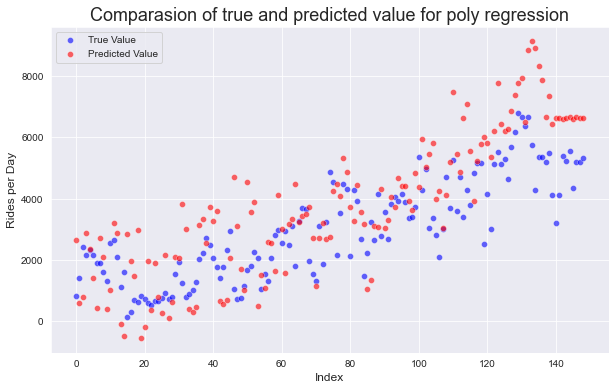

In [58]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = annual_data_poly, x = 'x_axis', y = 'true', color = 'b', label = 'True Value', alpha = 0.6)
sns.scatterplot(data = annual_data_poly, x = 'x_axis', y = 'predicted', color = 'r', label = 'Predicted Value', alpha = 0.6)

plt.title('Comparasion of true and predicted value for poly regression', fontsize = 18)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Rides per Day', fontsize=12)
plt.show()

In [59]:
#########################Casual Member#############################

In [60]:
merged_casual = merged_final_present.drop(columns = ['annual_members'])
merge_train_casual = merged_casual[(merged_casual['date'] < datetime.date(2021, 12, 31))]
merge_test_casual = merged_casual[(merged_casual['date'] > datetime.date(2021, 12 , 31))]
print(len(merge_train_casual))
print(len(merge_test_casual))

696
149


In [61]:
y_train_casual = pd.DataFrame(merge_train_casual['casual_members'].to_list(), 
                        index = merge_train_casual.index,
                        columns = ['num_annual'])
X_train_casual = merge_train_casual.drop(columns = ['casual_members', 'date'])

y_test_casual = pd.DataFrame(merge_test_casual['casual_members'].to_list(), 
                        index = merge_test_casual.index,
                        columns = ['num_annual'])
X_test_casual = merge_test_casual.drop(columns = ['casual_members', 'date'])

In [62]:
targets_casual = X_train_casual.columns

In [63]:
column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_exclude=['category'])),
        ('cat', OrdinalEncoder(), selector(dtype_include=['category']))],
        remainder='drop')
clf = RandomForestClassifier(random_state = 999, class_weight = 'balanced')
pipeline = Pipeline([('prep', column_trans),
                     ('clf', clf)])

pipeline.fit(X_train_casual, y_train_casual)
pipeline['clf'].feature_importances_

feat_list = []

In [64]:
total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(targets_casual, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]

included_feats = []
# Print the name and gini importance of each feature
for feature in zip(targets_casual, pipeline['clf'].feature_importances_):
    if feature[1] > .033:
        included_feats.append(feature[0])

print('\n',"Cumulative Importance =", total_importance)

# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp

print('Most Important Features:')
print(included_feats)
print('Number of Included Features =', len(included_feats))


 Cumulative Importance = 1.0
Most Important Features:
['infection_detection', 'temp', 'dew_temp', 'rh', 'press']
Number of Included Features = 5


In [65]:
selected_fea_casual = included_feats

In [66]:
################Linear regression for casual member##################

In [67]:
linear_model_casual = LinearRegression(fit_intercept = True)
linear_model_casual.fit(X_train_casual[selected_fea_casual], y_train_casual)
y_fitted_casual = linear_model_casual.predict(X_train_casual[selected_fea_casual])

In [68]:
training_error_casual = rmse(y_train_casual, y_fitted_casual)
training_mae_casual = mean_absolute_error(y_train_casual, y_fitted_casual)
r2_score_training_casual = r2_score(y_train_casual, y_fitted_casual)

print('Training RMSE: {}'.format(training_error_casual))
print('Training MAE: {}'.format(training_mae_casual))
print('Training R2 score: {}'.format(r2_score_training_casual))

Training RMSE: num_annual    2226.080603
dtype: float64
Training MAE: 1661.7154790958227
Training R2 score: 0.4416701741229705


In [69]:
# Prediction on test set
y_pred_test_casual = linear_model_casual.predict(X_test_casual[selected_fea_casual])

test_error_casual = rmse(y_test_casual, y_pred_test_casual)
test_mae_casual = mean_absolute_error(y_test_casual, y_pred_test_casual)
r2_score_test_casual = r2_score(y_test_casual, y_pred_test_casual)

print('Test RMSE: {}'.format(test_error_casual))
print('Test MAE: {}'.format(test_mae_casual))
print('Test R2 score: {}'.format(r2_score_test_casual)) 

Test RMSE: num_annual    3537.146502
dtype: float64
Test MAE: 2085.8663162711678
Test R2 score: 0.28726188213997206


In [70]:
x_axis_casual = np.arange(len(y_test_casual))
casual_data = pd.concat([pd.DataFrame(x_axis_casual), y_test_casual.reset_index(), pd.DataFrame(y_pred_test_casual)],axis =1, ignore_index = True)
casual_data.columns = ['x_axis', 'index', 'true', 'predicted']

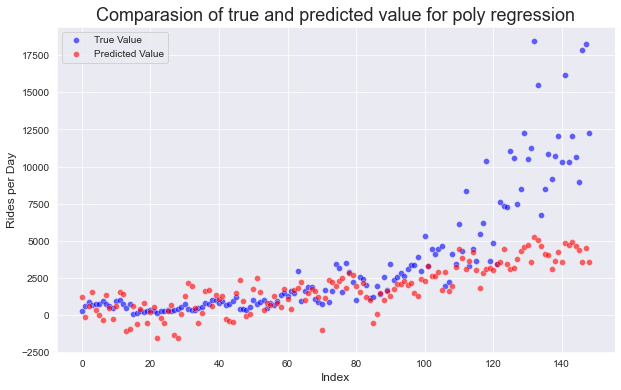

In [71]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = casual_data, x = 'x_axis', y = 'true', color = 'b', label = 'True Value', alpha = 0.6)
sns.scatterplot(data = casual_data, x = 'x_axis', y = 'predicted', color = 'r', label = 'Predicted Value', alpha = 0.6)

plt.title('Comparasion of true and predicted value for poly regression', fontsize = 18)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Rides per Day', fontsize=12)
plt.show()

In [72]:
####################Poly regression for casual member###############

In [73]:
from sklearn.preprocessing import PolynomialFeatures
  
poly_model_casual = PolynomialFeatures(degree = 2)
X_train_casual_poly = poly_model_casual.fit_transform(X_train_casual[selected_fea_casual])
linear_model_casual_poly = LinearRegression(fit_intercept = True)
linear_model_casual_poly.fit(X_train_casual_poly, y_train_casual)
y_fitted_casual_poly = linear_model_casual_poly.predict(X_train_casual_poly)

In [74]:
training_error_casual_poly = rmse(y_train_casual, y_fitted_casual_poly)
training_mae_casual_poly = mean_absolute_error(y_train_casual, y_fitted_casual_poly)
r2_score_training_casual_poly = r2_score(y_train_casual, y_fitted_casual_poly)

print('Training RMSE: {}'.format(training_error_casual_poly))
print('Training MAE: {}'.format(training_mae_casual_poly))
print('Training R2 score: {}'.format(r2_score_training_casual_poly))

Training RMSE: num_annual    2154.550015
dtype: float64
Training MAE: 1602.187684651462
Training R2 score: 0.47697527732635436


In [75]:
X_test_casual_poly = poly_model_casual.fit_transform(X_test_casual[selected_fea_casual])  
y_pred_test_casual_poly = linear_model_casual_poly.predict(X_test_casual_poly)

test_error_casual_poly = rmse(y_test_casual, y_pred_test_casual_poly)
test_mae_casual_poly = mean_absolute_error(y_test_casual, y_pred_test_casual_poly)
r2_score_test_casual_poly = r2_score(y_test_casual, y_pred_test_casual_poly)

print('Test RMSE: {}'.format(test_error_casual_poly))
print('Test MAE: {}'.format(test_mae_annual_poly))
print('Test R2 score: {}'.format(r2_score_test_casual_poly))

Test RMSE: num_annual    4309.560954
dtype: float64
Test MAE: 1260.600536972689
Test R2 score: -0.058010421374594


In [76]:
x_axis_casual_poly = np.arange(len(y_test_casual))
casual_data_poly = pd.concat([pd.DataFrame(x_axis_casual_poly), y_test_casual.reset_index(), pd.DataFrame(y_pred_test_casual_poly)],axis =1, ignore_index = True)
casual_data_poly.columns = ['x_axis', 'index', 'true', 'predicted']

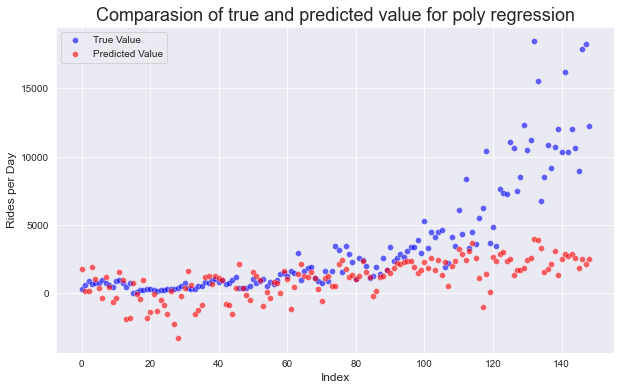

In [77]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = casual_data_poly, x = 'x_axis', y = 'true', color = 'b', label = 'True Value', alpha = 0.6)
sns.scatterplot(data = casual_data_poly, x = 'x_axis', y = 'predicted', color = 'r', label = 'Predicted Value', alpha = 0.6)

plt.title('Comparasion of true and predicted value for poly regression', fontsize = 18)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Rides per Day', fontsize=12)
plt.show()

In [78]:
#####################Prediction###################

In [79]:
merged_final_future.head()

,date,inf_mean,seir_cumulative_mean,inf_cuml_mean,seir_daily_mean,seir_daily_unscaled_mean,seir_cumulative_unscaled_mean,cases_mean,inf_cuml_mean_vax,inf_cuml_mean_unvax,...,rh,prec,wind_dir,wind_speed,visibility,press,hmdx,wind_chill,weather_clear,workday_True
846,2022-05-30,57500.72,56236.92,29031094.05,66.84,42.09,41421.86,2380.99,1.917371e+07,6.700755e+06,...,68.65,0.0,26.000000,11.0,16.1,100.46,29.744681,-10.992366,1,1
847,2022-05-31,58963.04,56297.36,29090057.09,60.45,37.47,41459.33,2326.80,1.920783e+07,6.705389e+06,...,75.00,0.0,28.000000,15.0,16.1,100.28,29.744681,-10.992366,1,1
848,2022-06-01,60943.72,56352.81,29151000.81,55.45,33.85,41493.17,2259.77,1.924297e+07,6.710176e+06,...,62.00,0.0,33.000000,11.0,16.1,99.96,26.000000,-10.992366,1,1
849,2022-06-02,63492.51,56406.03,29214493.32,53.22,32.32,41525.49,2214.25,1.927945e+07,6.715157e+06,...,42.00,0.0,30.000000,22.0,16.1,99.90,29.744681,-10.992366,1,1
850,2022-06-03,66779.06,56459.24,29281272.38,53.21,32.46,41557.95,2203.73,1.931767e+07,6.720387e+06,...,78.00,0.0,20.059618,8.0,16.1,100.06,29.744681,-10.992366,1,1


In [80]:
X_annual_future = merged_final_future[selected_fea_annual]

In [81]:
# linear fit for annual
y_predict_future_annual = linear_model_annual.predict(X_annual_future)
y_future_annual = pd.DataFrame(merged_final_future['annual_members'])

future_error_annual = rmse(y_future_annual, y_predict_future_annual)
future_mae_annual = mean_absolute_error(y_future_annual, y_predict_future_annual)
future_r2_score_annual = r2_score(y_future_annual, y_predict_future_annual)

print('Test RMSE: {}'.format(future_error_annual))
print('Test MAE: {}'.format(future_mae_annual))
print('Test R2 score: {}'.format(future_r2_score_annual))

Test RMSE: annual_members    2792.567268
dtype: float64
Test MAE: 2368.3579795987043
Test R2 score: 0.02602475253247305


In [82]:
x_axis_future_annual = np.arange(len(y_future_annual))
future_annual_data = pd.concat([pd.DataFrame(x_axis_future_annual), y_future_annual.reset_index(), pd.DataFrame(y_predict_future_annual)],axis =1, ignore_index = True)
future_annual_data.columns = ['x_axis', 'index', 'true', 'predicted']

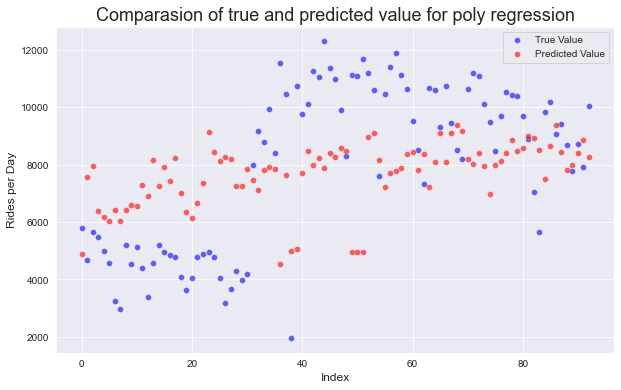

In [83]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = future_annual_data, x = 'x_axis', y = 'true', color = 'b', label = 'True Value', alpha = 0.6)
sns.scatterplot(data = future_annual_data, x = 'x_axis', y = 'predicted', color = 'r', label = 'Predicted Value', alpha = 0.6)

plt.title('Comparasion of true and predicted value for poly regression', fontsize = 18)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Rides per Day', fontsize=12)
plt.show()

In [84]:
# poly fit for annual
X_annual_future_poly = poly_model_annual.fit_transform(X_annual_future[selected_fea_annual])
y_predict_future_annual_poly = pd.DataFrame(linear_model_annual_poly.predict(X_annual_future_poly))

future_error_annual_poly = rmse(y_future_annual, y_predict_future_annual_poly)
future_mae_annual_poly = mean_absolute_error(y_future_annual, y_predict_future_annual_poly)
future_r2_score_annual_poly = r2_score(y_future_annual, y_predict_future_annual_poly)

print('Test RMSE: {}'.format(future_error_annual_poly))
print('Test MAE: {}'.format(future_mae_annual_poly))
print('Test R2 score: {}'.format(future_r2_score_annual_poly))

Test RMSE: annual_members   NaN
0                NaN
dtype: float64
Test MAE: 2857.461831844204
Test R2 score: -0.564966885623605


In [85]:
x_axis_future_annual_poly = np.arange(len(y_future_annual))
future_annual_data_poly = pd.concat([pd.DataFrame(x_axis_future_annual_poly), y_future_annual.reset_index(), pd.DataFrame(y_predict_future_annual_poly)],axis =1, ignore_index = True)
future_annual_data_poly.columns = ['x_axis', 'index', 'true', 'predicted']

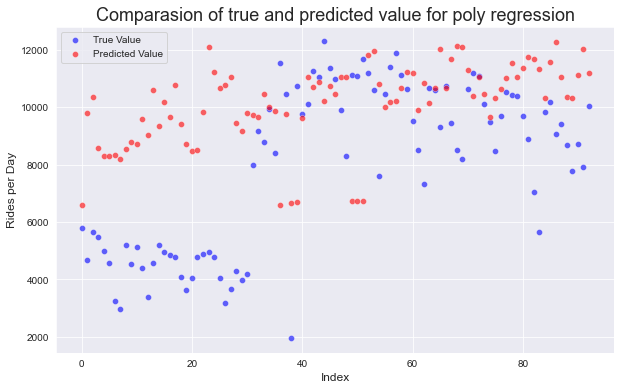

In [86]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = future_annual_data_poly, x = 'x_axis', y = 'true', color = 'b', label = 'True Value', alpha = 0.6)
sns.scatterplot(data = future_annual_data_poly, x = 'x_axis', y = 'predicted', color = 'r', label = 'Predicted Value', alpha = 0.6)

plt.title('Comparasion of true and predicted value for poly regression', fontsize = 18)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Rides per Day', fontsize=12)
plt.show()

In [87]:
X_casual_future = merged_final_future[selected_fea_casual]

In [88]:
# Linear fit for casual
y_predict_future_casual = linear_model_casual.predict(X_casual_future)
y_future_casual = pd.DataFrame(merged_final_future['casual_members'])

future_error_casual = rmse(y_future_casual, y_predict_future_casual)
future_mae_casual = mean_absolute_error(y_future_casual, y_predict_future_casual)
future_r2_score_casual = r2_score(y_future_casual, y_predict_future_casual)

print('Test RMSE: {}'.format(future_error_casual))
print('Test MAE: {}'.format(future_mae_casual))
print('Test R2 score: {}'.format(future_r2_score_casual))

Test RMSE: casual_members    7987.691915
dtype: float64
Test MAE: 7222.587078928223
Test R2 score: -4.213998560250558


In [89]:
x_axis_future_casual = np.arange(len(y_future_casual))
future_casual_data = pd.concat([pd.DataFrame(x_axis_future_casual), y_future_casual.reset_index(), pd.DataFrame(y_predict_future_casual)],axis =1, ignore_index = True)
future_casual_data.columns = ['x_axis', 'index', 'true', 'predicted']

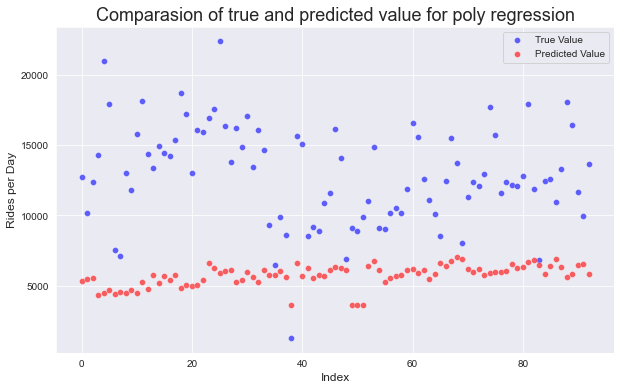

In [90]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = future_casual_data, x = 'x_axis', y = 'true', color = 'b', label = 'True Value', alpha = 0.6)
sns.scatterplot(data = future_casual_data, x = 'x_axis', y = 'predicted', color = 'r', label = 'Predicted Value', alpha = 0.6)

plt.title('Comparasion of true and predicted value for poly regression', fontsize = 18)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Rides per Day', fontsize=12)
plt.show()

In [91]:
# Poly fit for casual
X_casual_future_poly = poly_model_casual.fit_transform(X_casual_future)
y_predict_future_casual_poly = linear_model_casual_poly.predict(X_casual_future_poly)

future_error_casual_poly = rmse(y_future_casual, y_predict_future_casual_poly)
future_mae_casual_poly = mean_absolute_error(y_future_casual, y_predict_future_casual_poly)
future_r2_score_casual_poly = r2_score(y_future_casual, y_predict_future_casual_poly)

print('Test RMSE: {}'.format(future_error_casual_poly))
print('Test MAE: {}'.format(future_mae_casual_poly))
print('Test R2 score: {}'.format(future_r2_score_casual_poly))

Test RMSE: casual_members    10392.747005
dtype: float64
Test MAE: 9599.07757819676
Test R2 score: -7.826509759807143


In [92]:
x_axis_future_casual_poly = np.arange(len(y_future_casual))
future_casual_data_poly = pd.concat([pd.DataFrame(x_axis_future_casual_poly), y_future_casual.reset_index(), pd.DataFrame(y_predict_future_casual_poly)],axis =1, ignore_index = True)
future_casual_data_poly.columns = ['x_axis', 'index', 'true', 'predicted']

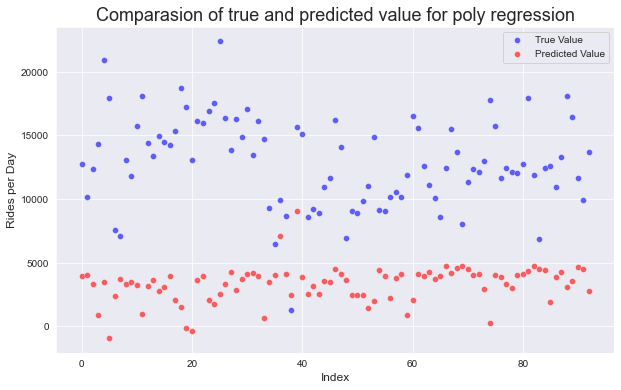

In [93]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = future_casual_data_poly, x = 'x_axis', y = 'true', color = 'b', label = 'True Value', alpha = 0.6)
sns.scatterplot(data = future_casual_data_poly, x = 'x_axis', y = 'predicted', color = 'r', label = 'Predicted Value', alpha = 0.6)

plt.title('Comparasion of true and predicted value for poly regression', fontsize = 18)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Rides per Day', fontsize=12)
plt.show()

In [96]:
summary_df = pd.DataFrame()
summary_df['casual_member'] = [r2_score_training_casual,r2_score_test_casual,r2_score_training_casual_poly,r2_score_test_casual_poly]
summary_df.index = ['train_linear_r2_score','val_linear_r2_score','train_poly_r2_score','val_poly_r2_score']
summary_df['annual_member'] = [r2_score_training_annual,r2_score_test_annual,r2_score_training_annual_poly,r2_score_test_annual_poly]
summary_df

,casual_member,annual_member
train_linear_r2_score,0.441670,0.645713
val_linear_r2_score,0.287262,0.531995
train_poly_r2_score,0.476975,0.685993
val_poly_r2_score,-0.058010,0.124262
